# Model Testing Notebook

**Objective:** Evaluate the pre-trained 20-hour XGBoost model on the test dataset.

In [58]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from feature_engineering import create_features

plt.style.use('fivethirtyeight')

### 1. Load Data and Model

In [59]:
try:
    # Load the model bundle
    bundle = joblib.load('xgb_rewaghat_model_bundle_20hr.pkl')
    model = bundle['model']
    feature_names = bundle['feature_names']
    print("Model bundle loaded successfully.")
except FileNotFoundError:
    print("Error: Model bundle 'xgb_rewaghat_model_bundle_20hr.pkl' not found.")
    exit()

try:
    # Load all necessary data files to reconstruct the full dataset
    old_chatia_df = pd.read_excel('Chatia_train.xlsx')
    old_rewaghat_df = pd.read_excel('Rewaghat_train.xlsx')
    new_chatia_df = pd.read_excel('Chatia_test.xlsx')
    new_rewaghat_df = pd.read_excel('Rewaghat_test.xlsx')
    rainfall_df = pd.read_excel('rainfall_data.xlsx')
    print("All data files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure all data files are in the correct locations.")
    exit()

# Combine datasets
full_chatia_df = pd.concat([old_chatia_df, new_chatia_df]).drop_duplicates(subset=['Date']).reset_index(drop=True)
full_rewaghat_df = pd.concat([old_rewaghat_df, new_rewaghat_df]).drop_duplicates(subset=['Date']).reset_index(drop=True)

full_chatia_df['Date'] = pd.to_datetime(full_chatia_df['Date'], format='%d-%m-%Y %H:%M')
full_rewaghat_df['Date'] = pd.to_datetime(full_rewaghat_df['Date'], format='%d-%m-%Y %H:%M')
rainfall_df['Date'] = pd.to_datetime(rainfall_df['Date'], format='%d-%m-%Y %H:%M')

df_bases = pd.merge(full_chatia_df, full_rewaghat_df, on='Date', how='inner')
df = pd.merge(df_bases, rainfall_df, on='Date', how='inner')

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

Model bundle loaded successfully.
All data files loaded successfully.
All data files loaded successfully.


### 2. Create Features and Prepare Test Set

In [60]:
# Create features using the imported function
df_model = create_features(df)

# Define the test set as the most recent year of data
test_df = df_model.loc[df_model.index >= (df_model.index.max() - pd.DateOffset(years=1))]

target = 'Rewaghat_20h_future'

X_test = test_df[feature_names]
y_test = test_df[target]

print(f"Test Set Shape: {X_test.shape}")

Test Set Shape: (8777, 86)


### 3. Run Predictions and Evaluate

In [61]:
y_pred = model.predict(X_test)

errors = y_pred - y_test
accuracy = np.sum((errors >= -0.15) & (errors <= 0.15)) / len(y_test) * 100
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"--- Model Evaluation on Test Set ---")
print(f"Custom Accuracy (±0.15m): {accuracy:.2f}%")
print(f"MAE: {mae:.4f} m")
print(f"RMSE: {rmse:.4f} m")

--- Model Evaluation on Test Set ---
Custom Accuracy (±0.15m): 86.35%
MAE: 0.0815 m
RMSE: 0.1638 m


### 4. Plot Results

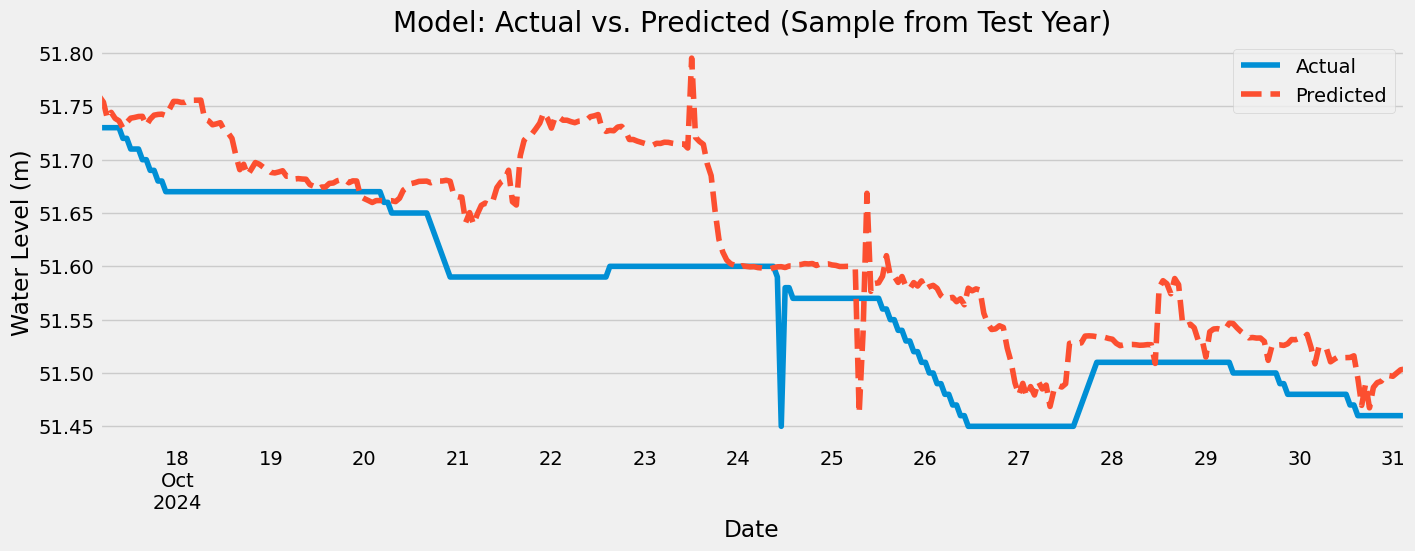

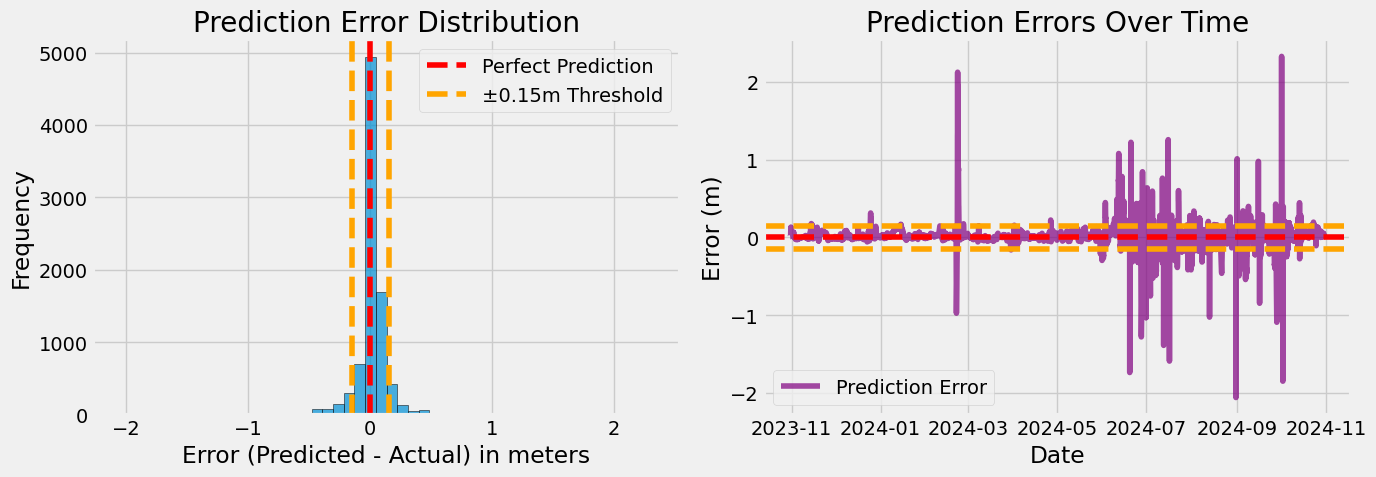

In [62]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

ax = results.tail(336).plot(figsize=(15, 5), style=['-', '--'], title='Model: Actual vs. Predicted (Sample from Test Year)')
ax.set_ylabel('Water Level (m)')
plt.grid(True)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(errors, bins=50, alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='red', linestyle='--', label='Perfect Prediction')
ax1.axvline(x=0.15, color='orange', linestyle='--', label='±0.15m Threshold')
ax1.axvline(x=-0.15, color='orange', linestyle='--')
ax1.set_title("Prediction Error Distribution")
ax1.set_xlabel("Error (Predicted - Actual) in meters")
ax1.set_ylabel("Frequency")
ax1.legend()

ax2.plot(results.index, errors, label='Prediction Error', color='purple', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--')
ax2.axhline(y=0.15, color='orange', linestyle='--')
ax2.axhline(y=-0.15, color='orange', linestyle='--')
ax2.set_title("Prediction Errors Over Time")
ax2.set_xlabel("Date")
ax2.set_ylabel("Error (m)")
ax2.legend()

plt.tight_layout()
plt.show()

### 5. Detailed Evaluation on `test.xlsx` data (June-Oct 2024)

In [63]:
# Define the date range for the test.xlsx data
start_date = '2024-06-01'
end_date = '2024-10-31'

# Filter the test set for this specific period
monsoon_df = test_df.loc[start_date:end_date]

X_monsoon = monsoon_df[feature_names]
y_monsoon = monsoon_df[target]

# Make predictions for this period
y_pred_monsoon = model.predict(X_monsoon)

# Evaluate the performance
errors_monsoon = y_pred_monsoon - y_monsoon
accuracy_monsoon = np.sum((errors_monsoon >= -0.15) & (errors_monsoon <= 0.15)) / len(y_monsoon) * 100
mae_monsoon = mean_absolute_error(y_monsoon, y_pred_monsoon)
rmse_monsoon = np.sqrt(mean_squared_error(y_monsoon, y_pred_monsoon))

print(f"--- Evaluation on Monsoon Period ({start_date} to {end_date}) ---")
print(f"Custom Accuracy (±0.15m): {accuracy_monsoon:.2f}%")
print(f"MAE: {mae_monsoon:.4f} m")
print(f"RMSE: {rmse_monsoon:.4f} m")

--- Evaluation on Monsoon Period (2024-06-01 to 2024-10-31) ---
Custom Accuracy (±0.15m): 70.55%
MAE: 0.1406 m
RMSE: 0.2248 m


### Monthly Performance Breakdown (Oct 2023 - Oct 2024)

In [64]:
month_year_list = sorted(set(zip(test_df.index.year, test_df.index.month)))
for year, month in month_year_list:
    monthly_df = test_df[(test_df.index.year == year) & (test_df.index.month == month)]
    
    if monthly_df.empty:
        print(f"No data for {month}/{year}")
        continue

    X_month = monthly_df[feature_names]
    y_month = monthly_df[target]

    y_pred_month = model.predict(X_month)

    errors_month = y_pred_month - y_month
    accuracy_month = np.sum((errors_month >= -0.15) & (errors_month <= 0.15)) / len(y_month) * 100
    mae_month = mean_absolute_error(y_month, y_pred_month)
    rmse_month = np.sqrt(mean_squared_error(y_month, y_pred_month))

    month_name = pd.to_datetime(f'{year}-{month}-01').strftime('%B %Y')
    print(f"--- {month_name} ---")
    print(f"Custom Accuracy (±0.15m): {accuracy_month:.2f}%")
    print(f"MAE: {mae_month:.4f} m")
    print(f"RMSE: {rmse_month:.4f} m\n")

--- October 2023 ---
Custom Accuracy (±0.15m): 100.00%
MAE: 0.0605 m
RMSE: 0.0697 m

--- November 2023 ---
Custom Accuracy (±0.15m): 97.22%
MAE: 0.0323 m
RMSE: 0.0472 m

--- December 2023 ---
Custom Accuracy (±0.15m): 98.12%
MAE: 0.0285 m
RMSE: 0.0489 m

--- January 2024 ---
Custom Accuracy (±0.15m): 98.92%
MAE: 0.0391 m
RMSE: 0.0562 m

--- February 2024 ---
Custom Accuracy (±0.15m): 92.96%
MAE: 0.0764 m
RMSE: 0.2400 m

--- March 2024 ---
Custom Accuracy (±0.15m): 99.60%
MAE: 0.0270 m
RMSE: 0.0375 m

--- April 2024 ---
Custom Accuracy (±0.15m): 99.17%
MAE: 0.0275 m
RMSE: 0.0404 m

--- May 2024 ---
Custom Accuracy (±0.15m): 96.64%
MAE: 0.0476 m
RMSE: 0.0651 m

--- June 2024 ---
Custom Accuracy (±0.15m): 54.07%
MAE: 0.2146 m
RMSE: 0.3198 m

--- July 2024 ---
Custom Accuracy (±0.15m): 62.50%
MAE: 0.1689 m
RMSE: 0.2392 m

--- August 2024 ---
Custom Accuracy (±0.15m): 83.20%
MAE: 0.0922 m
RMSE: 0.1463 m

--- September 2024 ---
Custom Accuracy (±0.15m): 67.64%
MAE: 0.1455 m
RMSE: 0.2195 m

-